# Restricted Boltzmann Machine - MNIST

## Imports

In [2]:
import sys, datetime
import os
from numba import njit, prange
from helper import *

import numpy as np
from numpy import exp,sqrt,log,log10,sign,power,cosh,sinh,tanh,floor
rng = np.random.default_rng(12345)
np.set_printoptions(precision=4)

import matplotlib as mpl
%matplotlib inline
from matplotlib.ticker import NullFormatter, MaxNLocator
mpl.rcParams.update({"font.size": 12})
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml

## Load data

In [3]:
X_original, Y_original = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

## Parameters

In [4]:
################################
#    CHOICE OF PARAMETERS      #
################################
# number of MNIST digits to keep (e.g., Ndigit=3 keeps 0,1,2)
Ndigit=3
# number of hidden units

dname='DATA/'
################################


## Select data, and digitalize them two levels

In [5]:
# Selecting digits to use
list_10_digits = ('0','1','2','3','4','5','6','7','8','9')
list_digits = list_10_digits[-Ndigit:] 
print('Chosen digits: ',list_digits)

# keep only X and Y in list_digitssssssssss
keep=np.isin(Y_original, list_digits)
X_keep,Y=X_original[keep],Y_original[keep]


#data,label = MNIST_bit(X_keep, x_min = x_min),Y
#data,label = data.astype("int"),label.astype("int")

# number of data points
#Nd = len(data)
# number of visible units - I.e. total pixels of the image
#D  = len(data[1])


Chosen digits:  ('7', '8', '9')


## Plotting data

In [6]:
#print(f"Extract of MNIST-{Ndigit} data points, binarized")
#for i in range(4): show_MNIST(data[i*20:],Nex=20)

## Contrastive divergence (CD)


In [6]:
# eq(213) page 97, activation via sigmoid
# taking into account energy gap 2 for "spin" variables (-1,1)
#@jit(parallel=True)
def CD_step(v_in,wei,bias, a_func=np.exp, details=False,POTTS=False):
    """
        Generates the state on the other layer: 
        Field "H" ->  activation "a" -> probability "p" -> Spins/bits v_out

        Either (v_in=x, wei=w) or (v_in=z, wei=w.T)

        details = True --> returns also probability (p) and activation (a) 

        POTTS means one-hot encoding (used only in hidden space)
    """
    # local "field"
    H = np.clip(np.dot(v_in.astype(np.float64), wei) + bias, a_min=-300, a_max=300)
    # "activation" note, it is a sigmoid
    a = a_func(level_gap*H)
    n = np.shape(H)
    v_out = np.full(n, x_min, dtype=int) # initially, just a list on -1's or 0's
    if POTTS: # RBM with a single hidden unit = 1 (that is, "one-hot encoding" with L states)
        # p: state probability, normalized to 1 over all units=states
        
        # Probability of turning on a hidden unit
        p = a/np.sum(a)
        # F: cumulative probability
        F = np.cumsum(p)
        # pick a state "i" randomly with probability p[i]
        r = np.random.rand()
        i = 0
        while r>F[i]:
            i+=1
        v_out[i] = 1 # activate a single hidden unit
    else: # normal Ising RBM
        # p: local probability, normalized to 1 for each hidden unit
        p = a / (a + 1.)
        # at each position i, activate the 1's with local probability p[i]
        v_out[np.random.random_sample(n) < p] = 1 

    if details: return (v_out,p,a)
    else: return v_out

## Plot weights

## Weights initialization 
The initialization proposed by Hinton for the bias $a_i$ of a visible unit $v_i$ is given by the formula $ a_i = \log(\frac{p_i}{1-p_i})$ (Hinton 2012), where $p_i$ is the fraction of training samples in which the unit $i$ is on. 
When updating the visible states, $p_i$ corresponds to the probability of having a visible state equal to 1, which is used to stochastically pick the value of each visible unit. The probability of activation for a visible neuron is $P(x_i=1|h)= \sigma(a_i + \sum_j h_j w_{ij})$ (Hinton 2012) where $\sigma(x) = \frac{1}{1+e^{-x}}$ is a sigmoid function. If we set $w_{ij}\sim 0$, we have $P(x_i=1) \sim \sigma(a_i)$, hence $\sigma(a_i) = p_i$.

The biases are set so that the neurons have on average an activation that matches the distribution of the training data (Mehta 2019). This helps stabilize learning and prevents the model from learning too slowly.
In a qualitative way, if a pixel is often active in the dataset ($p\sim 1$), the bias will be higly positive, encouraging the neuron to be active. On the contrary, if a pixel is rarely active ($p_i \sim 0$), the bias will be highly negative, discouraging activation. If $p_i = 0.5$, the bias will be zero, meaning the neuron has a neutral activation probability.

In the function $Hinton$ _ $bias$ _ $init(x)$ , an average on the data is made for each column obtaining the vector xmean.
The vector is then 'refined' setting values that are too close to the lower ($-1$ or $0$) and upper (1) state to a higher (first case) or lower value (second case). This is to avoid divergences when computing the logarithms. 
Finally, the function returns the vector of biases based on the formula above.

In [7]:
# initial bias of visible units, based on their average value in the dataset
# Hinton, "A Practical Guide to Training Restricted Boltzmann Machines"
def Hinton_bias_init(x):
    '''
    x ::shape of 'x'(data): (21770,784)
    xmean :: does the mean on 'data' for each column -> shape of xmean :(,784)
     xmin =0, xmax=1 if SPINS=FALSE, otherwise {-1,+1}
    since np.precision is set at 4 -> S = 1e-4
    level_gap :: is the difference in values between the max (1) and the min (x_min)
    np.clip :: avoid minimum maximum overflow, inf and -inf values.
    '''
    xmean=np.array(np.mean(x,axis=0))
    # remove values at extrema, to avoid divergences in the log's
    S = 1e-4
    x1,x2 = x_min+S,1-S 
    xmean[xmean<x1] = x1
    xmean[xmean>x2] = x2
    return (1/level_gap)*np.clip(log(xmean-x_min) - log(1-xmean),-300,300)
    


## Log-Likelihood


We trained the RBM on digits 7,8,9, trying with number of hidden units L $\in [3,4,5,6,7]$, and for each value we tried different CD steps, $Nt \in [2,4,6,8,10,12]$.

Log-likelihood generally increases during training, what you can see in the resume above are graphs of the LL taken every 5 epochs to spare us computational time and get as soon as possible an overview.

What we see is that number of CD steps matters a little bit in LL increase, 2-3 points, and it depends more on the number of hidden units. Best final values are for L=7. It is interesting to see that sometimes LL stalls after a initial steep increase. This could mean that the model fits the data soon, and then keeps wandering in the hyperspace. 

As Hinton suggests, best results with multidimensional data are reached with more hidden units than the necessary bits to describe the label, but would be optimal to have the same number of hidden units as the length of the data vector. With our computational capabilities this is very difficult to realize, it would mean 20-30 hidden units.



In [8]:
import numpy as np
import itertools as it

def generate_configurations(L):
    """Generate all binary configurations of length L."""
    return np.array(list(it.product((0,1), repeat=L)), dtype=np.int64)

def compute_log_likelihood(partition,data, a, b, w, configurations):
    log_likelihoods = np.zeros(len(data))  # Preallocate array
    #all_conf = generate_configurations(L)  # Compute binary configs once

    Hz_cache = np.array([H(a,w,z.astype(np.float64)) for z in configurations])  # Precompute H(z)

    for i, x in enumerate(data): 
        Z_x = 0.0
        for Hz, z in zip(Hz_cache, configurations):
            E_xz = -np.dot(Hz, x) - np.dot(b, z)
            Z_x += np.exp(-E_xz)

        log_likelihoods[i] = np.clip(np.log(Z_x) - partition, a_min=-700, a_max=+7000)

    return np.mean(log_likelihoods)

@njit(parallel=True)
def H(a,w,z):  
    return a + np.dot(w, z)  

@njit(parallel=True)
def G(b,z):  
    return np.prod(np.exp(b * z))

@njit(parallel=True)
def partition_function(a,w,b,configurations):
    sum_values = np.zeros(1, dtype=np.float64)#0.0  # Use scalar accumulation

    for i in prange(configurations.shape[0]):
        z = configurations[i]
        Hz = H(a,w,z.astype(np.float64))
        produttoria_H = np.prod(1 + np.exp(Hz))
        sum_values += G(b,z.astype(np.float64)) * produttoria_H

    return np.log(sum_values[0])

## Setting up RBM for cross validation

We use the same code used for training to perform a cross validation. This time we only select the 6 best models from the previous discussion.
In the code below are shown the hyperparameters of the last best model (number 5).

In [20]:
import time
## Hyper parameters::
L = 8
print(f'L, hidden units: {L}')

SPINS = False
print(f'SPINS: {SPINS}')

POTTS = False
print(f'POTTS: {POTTS}')

active = np.exp
print(f'activation func: {active}')

gamma = .001
print(f'gamma: {gamma}')

GRAD = 'RMSprop'
print(f'GRADa: {GRAD}')

# number of CD steps
Nt = 5
print(f'Nt: {Nt}')

Nepoch = 400
print(f'Epochs: {Nepoch}')

# number of minis
Nmini = 200
print(f'Nmini: {Nmini}')

N_ini = 10
print(f'Nini: {N_ini}')

N_fin = 30
print(f'Nfin: {N_fin}')

## momentum
m = 0
print(f'm: {m}')
      
## setup for gradient choice & gamma, momentum
if GRAD=="SGD":
    l_rate_ini,l_rate_fin=1.0,0.25
elif GRAD=="RMSprop":
    beta,epsilon=0.9,1e-4
    l_rate_ini,l_rate_fin=0.05,0.05
    print("epsilon=",epsilon)
else:
    l_rate_ini,l_rate_fin=0.05,0.05
    beta1, beta2, epsilon = .9, .999, 1e-4

##setup for spin/potts/other thing
if SPINS:
    x_min=-1
    level_gap=2.
else:
    x_min=0
    level_gap=1.

if POTTS:
    str_simul="RBM_Potts"
    Nz=L
else:
    str_simul="RBM"
    Nz=2**L
    
if POTTS and SPINS: 
    print("\n\n>>>>>>>> WARNING:  POTTS and SPINS cannot coexist\n\n")

# data binarization
data,label = MNIST_bit(X_keep),Y
data,label = data.astype("int"),label.astype("int")
# number of data points
Nd = len(data)
# number of visible units - I.e. total pixels of the image
D  = len(data[1])

# range of each initial weight
# Glorot and Bengio, "Understanding the difficulty of training deep feedforward neural networks"
sigma = sqrt(4. / float(L + D))

print(f"D={D}\tsample size\nL={L}\tnr. z states")
print("Gradient descent type:",GRAD)
print(f"learning rate        = {l_rate_ini} --> {l_rate_fin}")
if gamma!=0: print(f"gamma={gamma}\tregularization")

L, hidden units: 8
SPINS: False
POTTS: False
activation func: <ufunc 'exp'>
gamma: 0.001
GRADa: RMSprop
Nt: 5
Epochs: 400
Nmini: 200
Nini: 10
Nfin: 30
m: 0
epsilon= 0.0001
Dataset with 21076 points, each with 784 bits

D=784	sample size
L=8	nr. z states
Gradient descent type: RMSprop
learning rate        = 0.05 --> 0.05
gamma=0.001	regularization


## CV Run

We perform the cross validation by running the learning algorithm using different random seeds. 

Nepoch=400
Nmini=200


<Figure size 640x480 with 0 Axes>

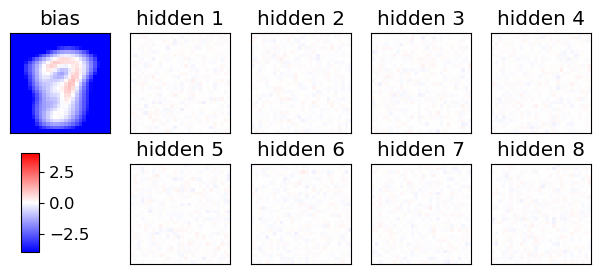

Starting the training
_20250327_0857
epoch 1 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 2 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 3 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 4 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 5 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 6 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 7 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 8 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 9 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 10 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

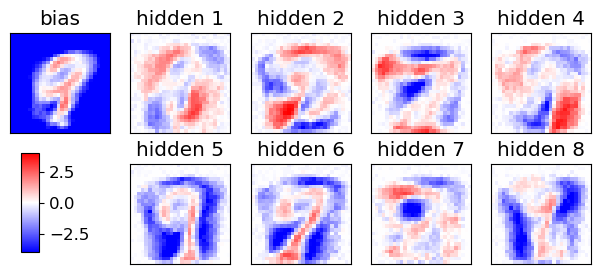

-151.0284396979768
epoch 11 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 12 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 13 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 14 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 15 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 16 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 17 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 18 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 19 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 20 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

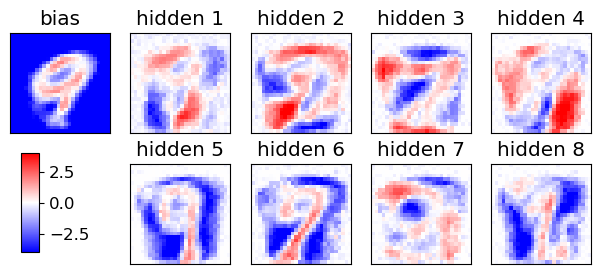

-149.90969896760703
epoch 21 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 22 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 23 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 24 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 25 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 26 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 27 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 28 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 29 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 30 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

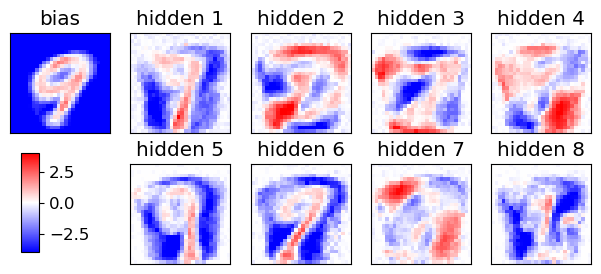

-148.74445201187416
epoch 31 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 32 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 33 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 34 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 35 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 36 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 37 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 38 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 39 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 40 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

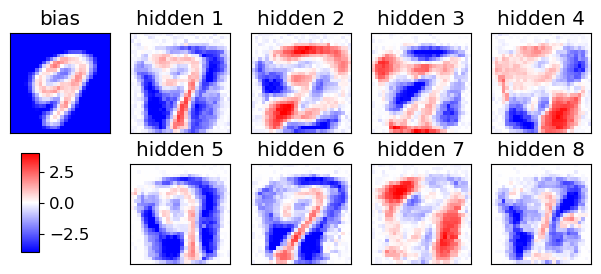

-149.18202793192765
epoch 41 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 42 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 43 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 44 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 45 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 46 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 47 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 48 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 49 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 50 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

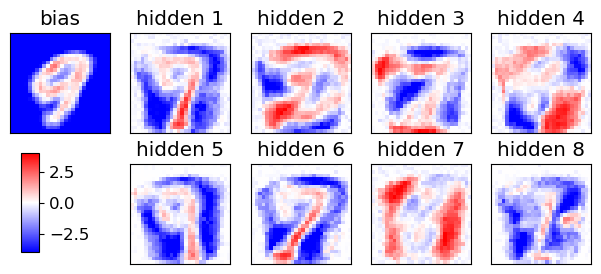

-153.67352849591722
epoch 51 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 52 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 53 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 54 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 55 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 56 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 57 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 58 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 59 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 60 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

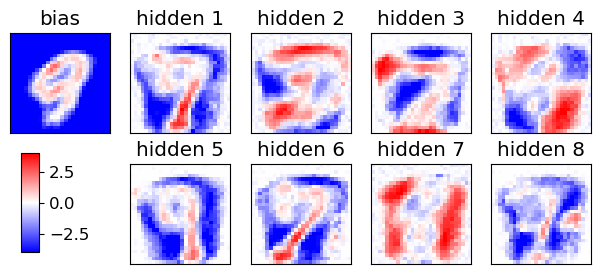

-151.85635378712493
epoch 61 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 62 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 63 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 64 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 65 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 66 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 67 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 68 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 69 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 70 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

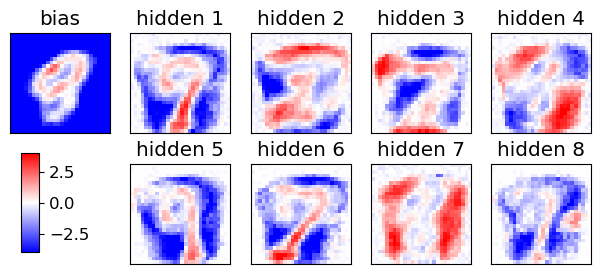

-147.0499342685825
epoch 71 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 72 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 73 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 74 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 75 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 76 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 77 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 78 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 79 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 80 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

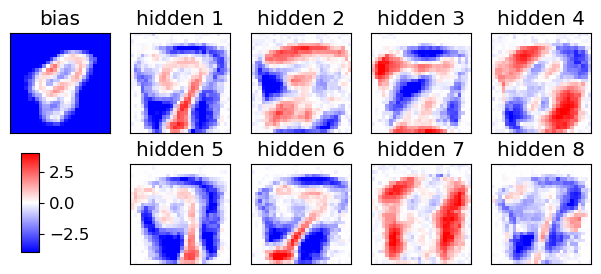

-149.7717317590856
epoch 81 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 82 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 83 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 84 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 85 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 86 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 87 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 88 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 89 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 90 / 400  Nt: 5  N: 10  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

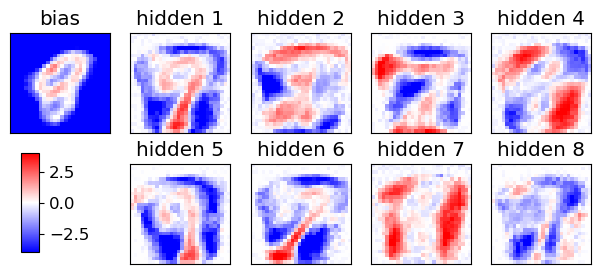

-153.65277479585137
epoch 91 / 400  Nt: 5  N: 11  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 92 / 400  Nt: 5  N: 11  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 93 / 400  Nt: 5  N: 11  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 94 / 400  Nt: 5  N: 11  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 95 / 400  Nt: 5  N: 11  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 96 / 400  Nt: 5  N: 11  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 97 / 400  Nt: 5  N: 11  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 98 / 400  Nt: 5  N: 11  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 99 / 400  Nt: 5  N: 11  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 100 / 400  Nt: 5  N: 11  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

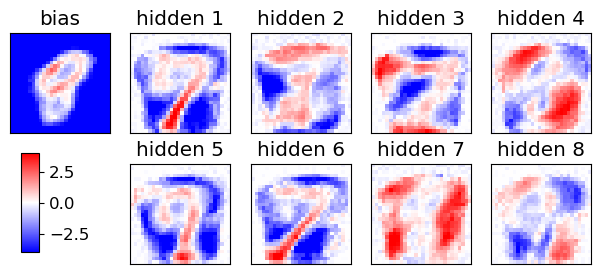

-156.53401589421196
epoch 101 / 400  Nt: 5  N: 11  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 102 / 400  Nt: 5  N: 11  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 103 / 400  Nt: 5  N: 11  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 104 / 400  Nt: 5  N: 11  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 105 / 400  Nt: 5  N: 11  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 106 / 400  Nt: 5  N: 11  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 107 / 400  Nt: 5  N: 11  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 108 / 400  Nt: 5  N: 11  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 109 / 400  Nt: 5  N: 11  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 110 / 400  Nt: 5  N: 11  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

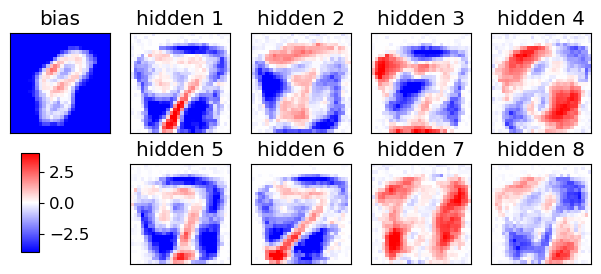

-148.82911530647615
epoch 111 / 400  Nt: 5  N: 11  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 112 / 400  Nt: 5  N: 11  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 113 / 400  Nt: 5  N: 11  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 114 / 400  Nt: 5  N: 11  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 115 / 400  Nt: 5  N: 11  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 116 / 400  Nt: 5  N: 11  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 117 / 400  Nt: 5  N: 11  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 118 / 400  Nt: 5  N: 11  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 119 / 400  Nt: 5  N: 11  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 120 / 400  Nt: 5  N: 11  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

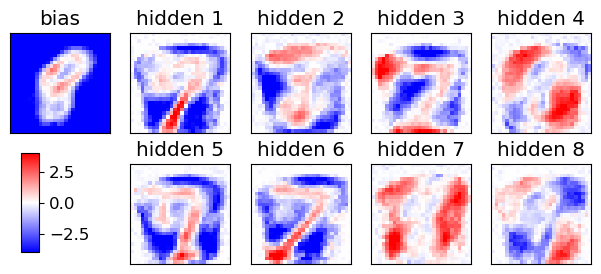

-151.3998496005379
epoch 121 / 400  Nt: 5  N: 11  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 122 / 400  Nt: 5  N: 11  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 123 / 400  Nt: 5  N: 11  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 124 / 400  Nt: 5  N: 11  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 125 / 400  Nt: 5  N: 11  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 126 / 400  Nt: 5  N: 11  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 127 / 400  Nt: 5  N: 11  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 128 / 400  Nt: 5  N: 12  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 129 / 400  Nt: 5  N: 12  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 130 / 400  Nt: 5  N: 12  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

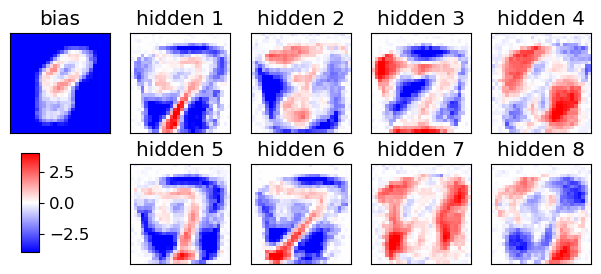

-150.74182953564673
epoch 131 / 400  Nt: 5  N: 12  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 132 / 400  Nt: 5  N: 12  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 133 / 400  Nt: 5  N: 12  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 134 / 400  Nt: 5  N: 12  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 135 / 400  Nt: 5  N: 12  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 136 / 400  Nt: 5  N: 12  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 137 / 400  Nt: 5  N: 12  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 138 / 400  Nt: 5  N: 12  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 139 / 400  Nt: 5  N: 12  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 140 / 400  Nt: 5  N: 12  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

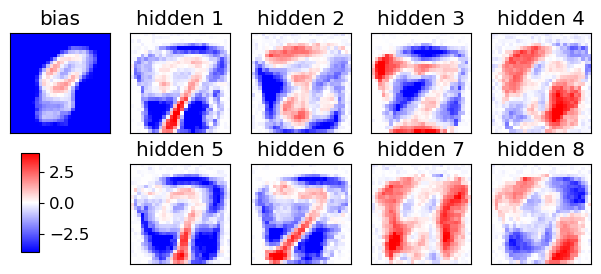

-152.11530318403013
epoch 141 / 400  Nt: 5  N: 12  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 142 / 400  Nt: 5  N: 12  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 143 / 400  Nt: 5  N: 12  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 144 / 400  Nt: 5  N: 12  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 145 / 400  Nt: 5  N: 12  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 146 / 400  Nt: 5  N: 12  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 147 / 400  Nt: 5  N: 12  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 148 / 400  Nt: 5  N: 12  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 149 / 400  Nt: 5  N: 12  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 150 / 400  Nt: 5  N: 12  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

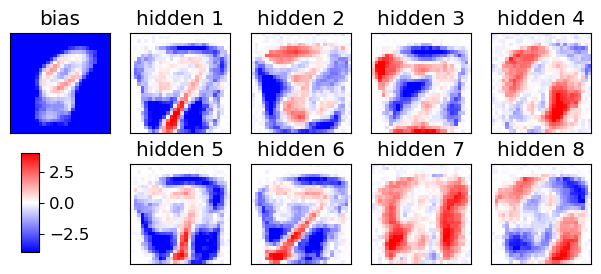

-152.80575584576474
epoch 151 / 400  Nt: 5  N: 12  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 152 / 400  Nt: 5  N: 12  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 153 / 400  Nt: 5  N: 12  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 154 / 400  Nt: 5  N: 12  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 155 / 400  Nt: 5  N: 12  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 156 / 400  Nt: 5  N: 13  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 157 / 400  Nt: 5  N: 13  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 158 / 400  Nt: 5  N: 13  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 159 / 400  Nt: 5  N: 13  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 160 / 400  Nt: 5  N: 13  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

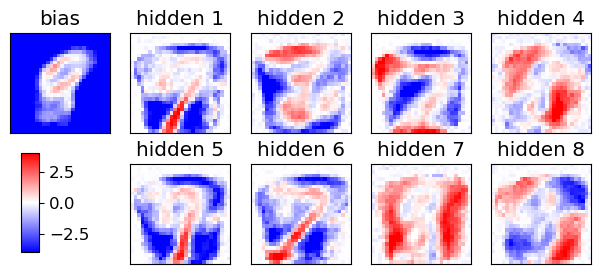

-147.36933918600909
epoch 161 / 400  Nt: 5  N: 13  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 162 / 400  Nt: 5  N: 13  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 163 / 400  Nt: 5  N: 13  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 164 / 400  Nt: 5  N: 13  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 165 / 400  Nt: 5  N: 13  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 166 / 400  Nt: 5  N: 13  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 167 / 400  Nt: 5  N: 13  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 168 / 400  Nt: 5  N: 13  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 169 / 400  Nt: 5  N: 13  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 170 / 400  Nt: 5  N: 13  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

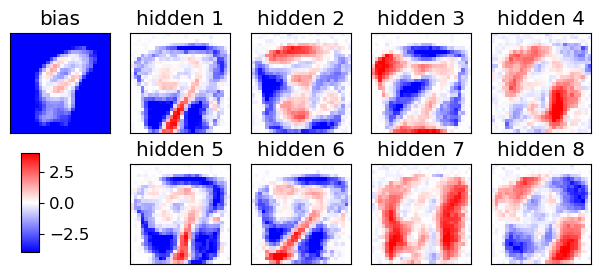

-143.8603555138988
epoch 171 / 400  Nt: 5  N: 13  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 172 / 400  Nt: 5  N: 13  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 173 / 400  Nt: 5  N: 13  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 174 / 400  Nt: 5  N: 13  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 175 / 400  Nt: 5  N: 13  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 176 / 400  Nt: 5  N: 13  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 177 / 400  Nt: 5  N: 13  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 178 / 400  Nt: 5  N: 13  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 179 / 400  Nt: 5  N: 13  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 180 / 400  Nt: 5  N: 14  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

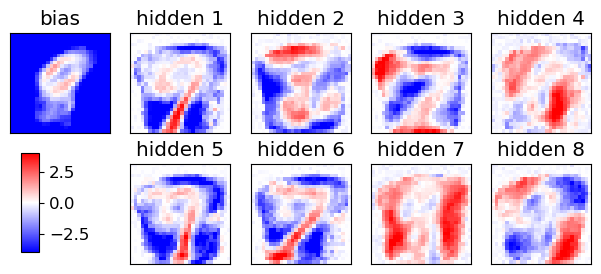

-146.25243831702568
epoch 181 / 400  Nt: 5  N: 14  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 182 / 400  Nt: 5  N: 14  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 183 / 400  Nt: 5  N: 14  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 184 / 400  Nt: 5  N: 14  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 185 / 400  Nt: 5  N: 14  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 186 / 400  Nt: 5  N: 14  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 187 / 400  Nt: 5  N: 14  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 188 / 400  Nt: 5  N: 14  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 189 / 400  Nt: 5  N: 14  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 190 / 400  Nt: 5  N: 14  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

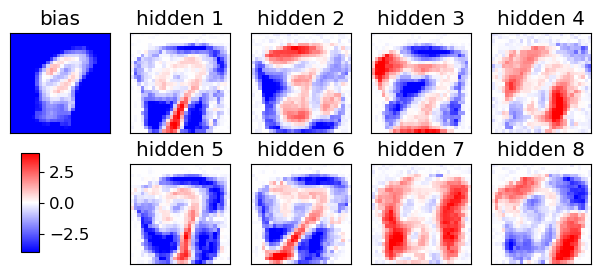

-151.1206969151605
epoch 191 / 400  Nt: 5  N: 14  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 192 / 400  Nt: 5  N: 14  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 193 / 400  Nt: 5  N: 14  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 194 / 400  Nt: 5  N: 14  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 195 / 400  Nt: 5  N: 14  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 196 / 400  Nt: 5  N: 14  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 197 / 400  Nt: 5  N: 14  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 198 / 400  Nt: 5  N: 14  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 199 / 400  Nt: 5  N: 14  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 200 / 400  Nt: 5  N: 14  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

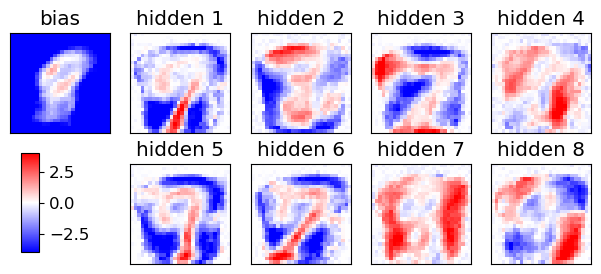

-148.0443707466425
epoch 201 / 400  Nt: 5  N: 15  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 202 / 400  Nt: 5  N: 15  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 203 / 400  Nt: 5  N: 15  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 204 / 400  Nt: 5  N: 15  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 205 / 400  Nt: 5  N: 15  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 206 / 400  Nt: 5  N: 15  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 207 / 400  Nt: 5  N: 15  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 208 / 400  Nt: 5  N: 15  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 209 / 400  Nt: 5  N: 15  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 210 / 400  Nt: 5  N: 15  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

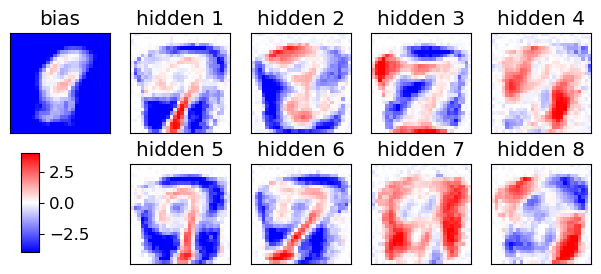

-153.2649787810236
epoch 211 / 400  Nt: 5  N: 15  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 212 / 400  Nt: 5  N: 15  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 213 / 400  Nt: 5  N: 15  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 214 / 400  Nt: 5  N: 15  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 215 / 400  Nt: 5  N: 15  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 216 / 400  Nt: 5  N: 15  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 217 / 400  Nt: 5  N: 15  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 218 / 400  Nt: 5  N: 15  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 219 / 400  Nt: 5  N: 15  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 220 / 400  Nt: 5  N: 16  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

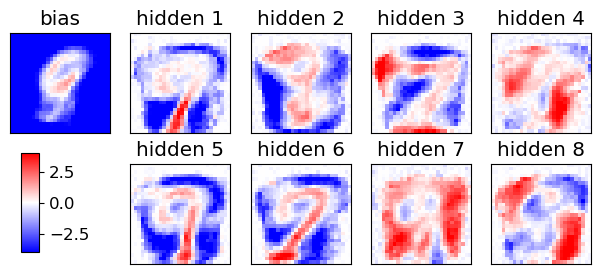

-151.75244626537653
epoch 221 / 400  Nt: 5  N: 16  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 222 / 400  Nt: 5  N: 16  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 223 / 400  Nt: 5  N: 16  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 224 / 400  Nt: 5  N: 16  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 225 / 400  Nt: 5  N: 16  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 226 / 400  Nt: 5  N: 16  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 227 / 400  Nt: 5  N: 16  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 228 / 400  Nt: 5  N: 16  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 229 / 400  Nt: 5  N: 16  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 230 / 400  Nt: 5  N: 16  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

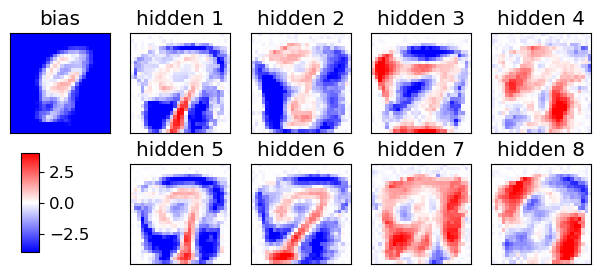

-149.8454416462024
epoch 231 / 400  Nt: 5  N: 16  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 232 / 400  Nt: 5  N: 16  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 233 / 400  Nt: 5  N: 16  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 234 / 400  Nt: 5  N: 16  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 235 / 400  Nt: 5  N: 16  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 236 / 400  Nt: 5  N: 16  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 237 / 400  Nt: 5  N: 16  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 238 / 400  Nt: 5  N: 17  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 239 / 400  Nt: 5  N: 17  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 240 / 400  Nt: 5  N: 17  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

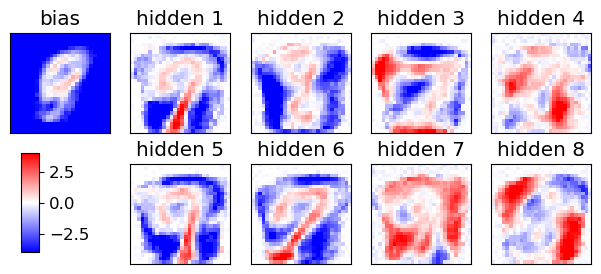

-147.76262991532104
epoch 241 / 400  Nt: 5  N: 17  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 242 / 400  Nt: 5  N: 17  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 243 / 400  Nt: 5  N: 17  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 244 / 400  Nt: 5  N: 17  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 245 / 400  Nt: 5  N: 17  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 246 / 400  Nt: 5  N: 17  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 247 / 400  Nt: 5  N: 17  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 248 / 400  Nt: 5  N: 17  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 249 / 400  Nt: 5  N: 17  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 250 / 400  Nt: 5  N: 17  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

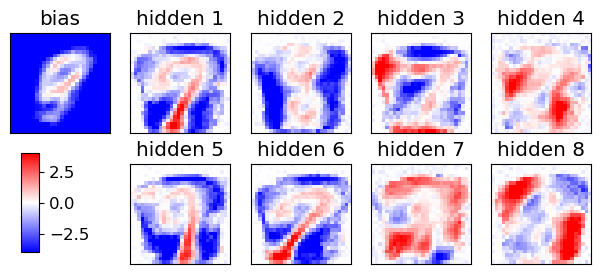

-149.8548688336574
epoch 251 / 400  Nt: 5  N: 17  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 252 / 400  Nt: 5  N: 17  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 253 / 400  Nt: 5  N: 17  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 254 / 400  Nt: 5  N: 18  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 255 / 400  Nt: 5  N: 18  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 256 / 400  Nt: 5  N: 18  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 257 / 400  Nt: 5  N: 18  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 258 / 400  Nt: 5  N: 18  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 259 / 400  Nt: 5  N: 18  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 260 / 400  Nt: 5  N: 18  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

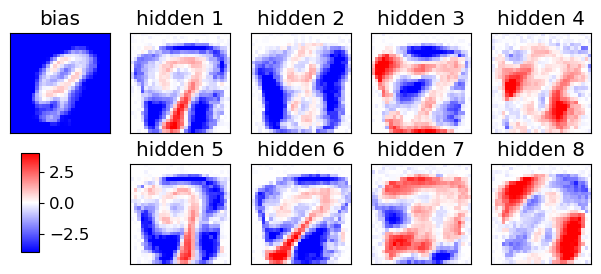

-147.9817731515903
epoch 261 / 400  Nt: 5  N: 18  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 262 / 400  Nt: 5  N: 18  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 263 / 400  Nt: 5  N: 18  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 264 / 400  Nt: 5  N: 18  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 265 / 400  Nt: 5  N: 18  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 266 / 400  Nt: 5  N: 18  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 267 / 400  Nt: 5  N: 18  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 268 / 400  Nt: 5  N: 18  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 269 / 400  Nt: 5  N: 19  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 270 / 400  Nt: 5  N: 19  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

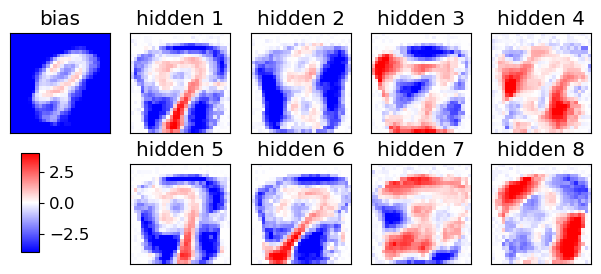

-148.4084928920251
epoch 271 / 400  Nt: 5  N: 19  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 272 / 400  Nt: 5  N: 19  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 273 / 400  Nt: 5  N: 19  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 274 / 400  Nt: 5  N: 19  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 275 / 400  Nt: 5  N: 19  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 276 / 400  Nt: 5  N: 19  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 277 / 400  Nt: 5  N: 19  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 278 / 400  Nt: 5  N: 19  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 279 / 400  Nt: 5  N: 19  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 280 / 400  Nt: 5  N: 19  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

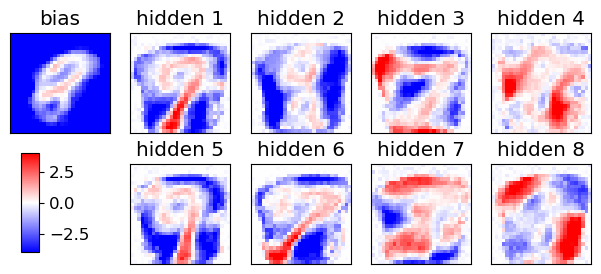

-150.23176431400597
epoch 281 / 400  Nt: 5  N: 19  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 282 / 400  Nt: 5  N: 19  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 283 / 400  Nt: 5  N: 19  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 284 / 400  Nt: 5  N: 20  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 285 / 400  Nt: 5  N: 20  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 286 / 400  Nt: 5  N: 20  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 287 / 400  Nt: 5  N: 20  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 288 / 400  Nt: 5  N: 20  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 289 / 400  Nt: 5  N: 20  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 290 / 400  Nt: 5  N: 20  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

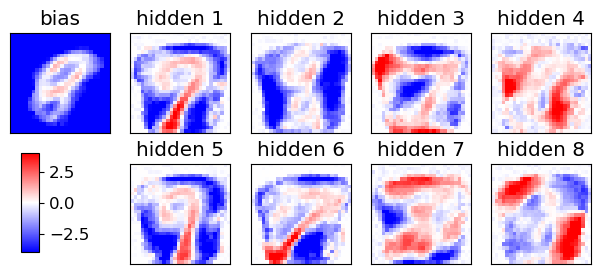

-147.5052526685231
epoch 291 / 400  Nt: 5  N: 20  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 292 / 400  Nt: 5  N: 20  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 293 / 400  Nt: 5  N: 20  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 294 / 400  Nt: 5  N: 20  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 295 / 400  Nt: 5  N: 20  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 296 / 400  Nt: 5  N: 20  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 297 / 400  Nt: 5  N: 21  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 298 / 400  Nt: 5  N: 21  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 299 / 400  Nt: 5  N: 21  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 300 / 400  Nt: 5  N: 21  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

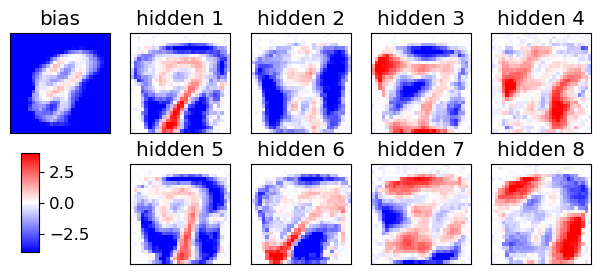

-144.10241413559314
epoch 301 / 400  Nt: 5  N: 21  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 302 / 400  Nt: 5  N: 21  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 303 / 400  Nt: 5  N: 21  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 304 / 400  Nt: 5  N: 21  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 305 / 400  Nt: 5  N: 21  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 306 / 400  Nt: 5  N: 21  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 307 / 400  Nt: 5  N: 21  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 308 / 400  Nt: 5  N: 21  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 309 / 400  Nt: 5  N: 21  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 310 / 400  Nt: 5  N: 21  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

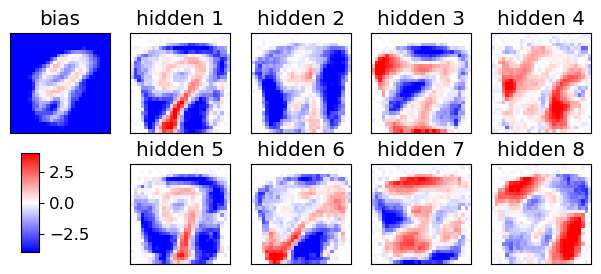

-151.2763731440363
epoch 311 / 400  Nt: 5  N: 22  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 312 / 400  Nt: 5  N: 22  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 313 / 400  Nt: 5  N: 22  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 314 / 400  Nt: 5  N: 22  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 315 / 400  Nt: 5  N: 22  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 316 / 400  Nt: 5  N: 22  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 317 / 400  Nt: 5  N: 22  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 318 / 400  Nt: 5  N: 22  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 319 / 400  Nt: 5  N: 22  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 320 / 400  Nt: 5  N: 22  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

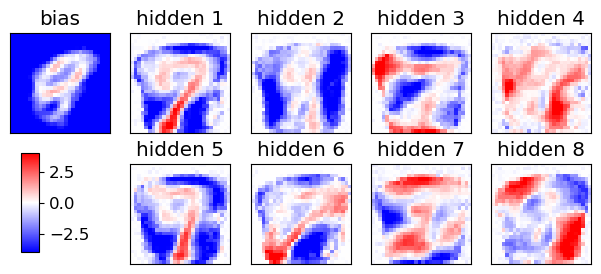

-148.77968862349329
epoch 321 / 400  Nt: 5  N: 22  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 322 / 400  Nt: 5  N: 22  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 323 / 400  Nt: 5  N: 23  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 324 / 400  Nt: 5  N: 23  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 325 / 400  Nt: 5  N: 23  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 326 / 400  Nt: 5  N: 23  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 327 / 400  Nt: 5  N: 23  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 328 / 400  Nt: 5  N: 23  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 329 / 400  Nt: 5  N: 23  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 330 / 400  Nt: 5  N: 23  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

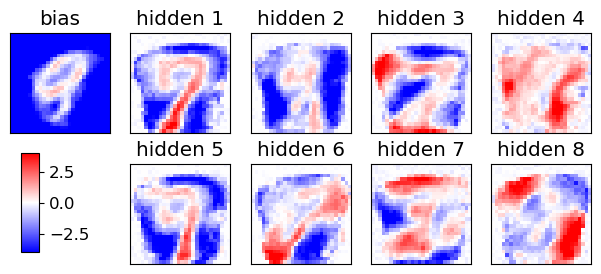

-147.49596804570982
epoch 331 / 400  Nt: 5  N: 23  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 332 / 400  Nt: 5  N: 23  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 333 / 400  Nt: 5  N: 23  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 334 / 400  Nt: 5  N: 23  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 335 / 400  Nt: 5  N: 24  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 336 / 400  Nt: 5  N: 24  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 337 / 400  Nt: 5  N: 24  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 338 / 400  Nt: 5  N: 24  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 339 / 400  Nt: 5  N: 24  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 340 / 400  Nt: 5  N: 24  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

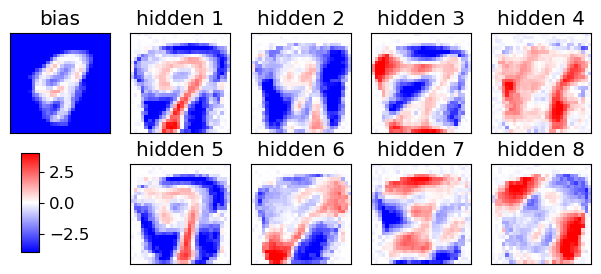

-143.71496275624492
epoch 341 / 400  Nt: 5  N: 24  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 342 / 400  Nt: 5  N: 24  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 343 / 400  Nt: 5  N: 24  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 344 / 400  Nt: 5  N: 24  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 345 / 400  Nt: 5  N: 24  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 346 / 400  Nt: 5  N: 24  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 347 / 400  Nt: 5  N: 25  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 348 / 400  Nt: 5  N: 25  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 349 / 400  Nt: 5  N: 25  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 350 / 400  Nt: 5  N: 25  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

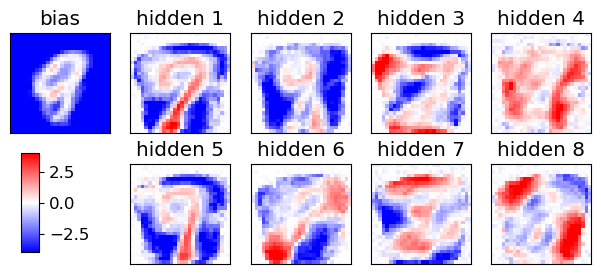

-148.26077980158104
epoch 351 / 400  Nt: 5  N: 25  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 352 / 400  Nt: 5  N: 25  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 353 / 400  Nt: 5  N: 25  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 354 / 400  Nt: 5  N: 25  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 355 / 400  Nt: 5  N: 25  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 356 / 400  Nt: 5  N: 25  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 357 / 400  Nt: 5  N: 25  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 358 / 400  Nt: 5  N: 26  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 359 / 400  Nt: 5  N: 26  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 360 / 400  Nt: 5  N: 26  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

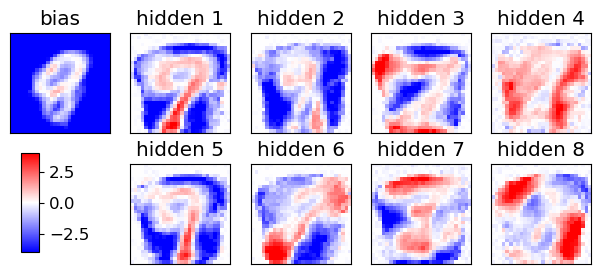

-147.02353373349203
epoch 361 / 400  Nt: 5  N: 26  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 362 / 400  Nt: 5  N: 26  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 363 / 400  Nt: 5  N: 26  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 364 / 400  Nt: 5  N: 26  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 365 / 400  Nt: 5  N: 26  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 366 / 400  Nt: 5  N: 26  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 367 / 400  Nt: 5  N: 26  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 368 / 400  Nt: 5  N: 26  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 369 / 400  Nt: 5  N: 27  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 370 / 400  Nt: 5  N: 27  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

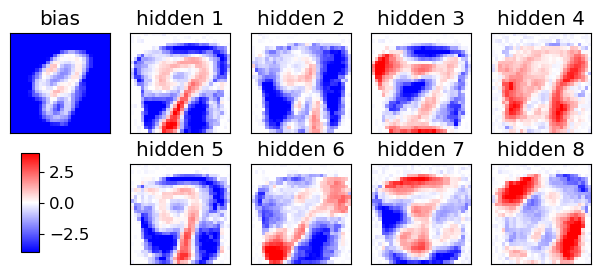

-145.49717243028525
epoch 371 / 400  Nt: 5  N: 27  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 372 / 400  Nt: 5  N: 27  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 373 / 400  Nt: 5  N: 27  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 374 / 400  Nt: 5  N: 27  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 375 / 400  Nt: 5  N: 27  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 376 / 400  Nt: 5  N: 27  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 377 / 400  Nt: 5  N: 27  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 378 / 400  Nt: 5  N: 27  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 379 / 400  Nt: 5  N: 27  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 380 / 400  Nt: 5  N: 28  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

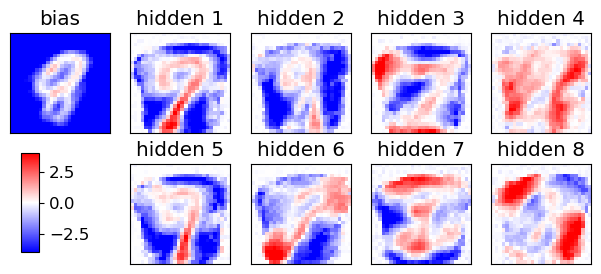

-146.7925339544873
epoch 381 / 400  Nt: 5  N: 28  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 382 / 400  Nt: 5  N: 28  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 383 / 400  Nt: 5  N: 28  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 384 / 400  Nt: 5  N: 28  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 385 / 400  Nt: 5  N: 28  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 386 / 400  Nt: 5  N: 28  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 387 / 400  Nt: 5  N: 28  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 388 / 400  Nt: 5  N: 28  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 389 / 400  Nt: 5  N: 28  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 390 / 400  Nt: 5  N: 29  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

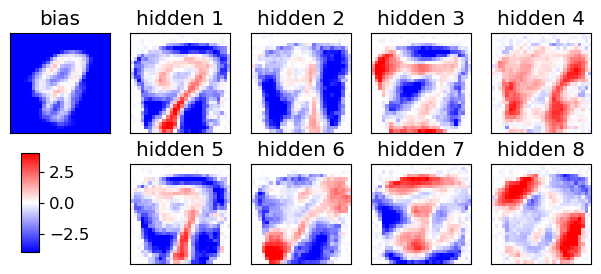

-147.13825083830884
epoch 391 / 400  Nt: 5  N: 29  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 392 / 400  Nt: 5  N: 29  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 393 / 400  Nt: 5  N: 29  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 394 / 400  Nt: 5  N: 29  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 395 / 400  Nt: 5  N: 29  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 396 / 400  Nt: 5  N: 29  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 397 / 400  Nt: 5  N: 29  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 398 / 400  Nt: 5  N: 29  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 399 / 400  Nt: 5  N: 29  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 400 / 400  Nt: 5  N: 30  L: 8  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

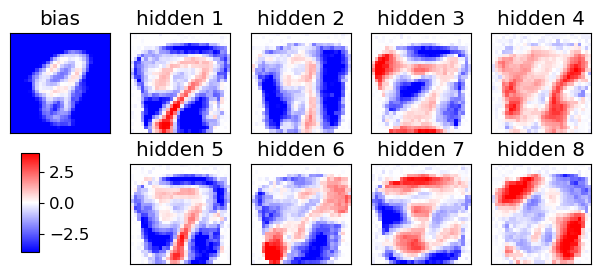

-148.00717957764755
END of learning phase _20250327_0920


In [14]:
for seed in [1]:#, 12, 123, 1234, 12345, 123457]:
    np.random.seed(seed)
    
    # initial weights from a Normal distr. (see literature, e.g. page 98 of Mehta's review)
    w = sigma * np.random.randn(D,L)
    # using Hinton initialization of visible biases
    a = Hinton_bias_init(data)
    # hidden biases initialized to zero
    b = np.zeros(L)
    print(f"Nepoch={Nepoch}\nNmini={Nmini}")
    # recording history of weights ("E" means epoch)
    wE,aE,bE=np.zeros((Nepoch+1,D,L)),np.zeros((Nepoch+1,D)),np.zeros((Nepoch+1,L)) 
    wE[0],aE[0],bE[0]=np.copy(w),np.copy(a),np.copy(b)
    gwE,gw2E,gwE_d,gwE_m = np.zeros_like(wE),np.zeros_like(wE),np.zeros_like(wE),np.zeros_like(wE)
    gaE,ga2E,gaE_d,gaE_m = np.zeros_like(aE),np.zeros_like(aE),np.zeros_like(aE),np.zeros_like(aE)
    gbE,gb2E,gbE_d,gbE_m = np.zeros_like(bE),np.zeros_like(bE),np.zeros_like(bE),np.zeros_like(bE)
    miniE = np.zeros(Nepoch+1)
    pzE=np.zeros((Nepoch+1,Nz))
    
    if m > 0: 
        bw = np.zeros_like(w)
        ba = np.zeros_like(a)
        bb = np.zeros_like(b)
    
    if GRAD=="RMSprop": 
        gw2,ga2,gb2 = np.zeros_like(w),np.zeros_like(a),np.zeros_like(b)
    
    elif GRAD=='Adam':
        mw, ma, mb = np.zeros_like(w), np.zeros_like(a), np.zeros_like(b)
        vw, va, vb = np.zeros_like(w), np.zeros_like(a), np.zeros_like(b)

    
    indices=np.arange(Nd).astype("int")
    plot_weights_bias(wE, aE, 0, L, cols=L//2, save=False)
    
    # for the plot with panels
    Ncols=min(8,max(2,L//2))
    
    if POTTS: print("Starting the training, POTTS=True")
    else: print("Starting the training")
    print(datetime.datetime.now().strftime("_%Y%m%d_%H%M"))
    
    configurations = generate_configurations(L)
    log_likelihoods = []
    lista_epoch_grafico = []
    # Note: here an epoch does not analyze the whole dataset
    for epoch in range(1,1+Nepoch):
        # q maps epochs to interval [0,1]
        q = (epoch-1.)/(Nepoch-1.) 
        # N, size of the mini batch
        # stays closer to N_ini for some time, then it progressively accelerates toward N_fin
        N = int(N_ini + (N_fin-N_ini)*(q**2))
        #  l_rate interpolates between initial and final value
        l_rate = l_rate_ini + (l_rate_fin-l_rate_ini)*q
    
        for mini in range(Nmini):
            # initializitation for averages in minibatch
            # visible variables "v" --> "x"
            #  hidden variables "h" --> "z"
            x_data, x_model = np.zeros(D),np.zeros(D)
            z_data, z_model = np.zeros(L),np.zeros(L)
            xz_data,xz_model= np.zeros((D,L)),np.zeros((D,L))
            pz = np.zeros(L)
    
            # Minibatch of size N: points randomply picked (without repetition) from data
            selected = np.random.choice(indices,N,replace=False)
           # if epoch==1 and mini<=3: print(selected)
    
            for k in range(N):
                ###################################
                x0 = data[selected[k]]
                # positive CD phase: generating z from x[k]
                z = CD_step(x0,w,b,a_func=active,POTTS=POTTS)
                x_data  += x0
                z_data  += z
                xz_data += np.outer(x0,z)
                # fantasy
                zf=np.copy(z)
                # Contrastive divergence with Nt steps
                for t in range(Nt):
                    # negative CD pzase: generating fantasy xf from fantasy zf
                    xf = CD_step(zf,w.T, a, a_func=active)
                    # positive CD phase: generating fantasy zf from fantasy xf 
                    zf = CD_step(xf,w,b,a_func=active,POTTS=POTTS)
                x_model += xf
                z_model += zf
                xz_model+= np.outer(xf,zf)
                # recording probability of encoding in z-space, if POTTS
                if POTTS: pz[zf]+=1
                ###################################
    
            # gradient of the likelihood: follow it along its positive direction
            gw_d,gw_m = xz_data/N, xz_model/N
            ga_d,ga_m = x_data/N, x_model/N
            gb_d,gb_m = z_data/N, z_model/N
            gw=np.copy(gw_d - gw_m)
            ga=np.copy(ga_d - ga_m)
            gb=np.copy(gb_d - gb_m)
    
            # gradient ascent step
            if GRAD=="RMSprop":
                # RMSprop gradient ascent
                gw2 = beta*gw2+(1-beta)*np.square(gw)
                ga2 = beta*ga2+(1-beta)*np.square(ga)
                gb2 = beta*gb2+(1-beta)*np.square(gb)
                if m > 0:
                    bw = m * bw + gw / sqrt(epsilon+gw2)
                    ba = m * ba + ga / sqrt(epsilon+ga2)
                    bb = m * bb + gb / sqrt(epsilon+gb2)
                    
                    w += l_rate * bw
                    a += l_rate * ba
                    b += l_rate * bb
                else:
                    w += l_rate*gw/sqrt(epsilon+gw2)
                    a += l_rate*ga/sqrt(epsilon+ga2)
                    b += l_rate*gb/sqrt(epsilon+gb2)
                    
                
            elif GRAD=='SGD': 
                # defaulting to the vanilla stochastic gradient ascent (SGD)
                if m > 0:
                    bw = m * bw + gw
                    ba = m * bw + ga
                    bb = m * bw + gb
                    gw = bw, ga = ba, gb = bb
                w += l_rate*gw
                a += l_rate*ga
                b += l_rate*gb

            else:
                # Adam
                mw = beta1 * mw + (1 - beta1) * gw
                ma = beta1 * ma + (1 - beta1) * ga
                mb = beta1 * mb + (1 - beta1) * gb
                
                vw = beta2 * vw + (1 - beta2) * np.square(gw)
                va = beta2 * va + (1 - beta2) * np.square(ga)
                vb = beta2 * vb + (1 - beta2) * np.square(gb)
                
                mwhat = mw / (1 - beta1 ** (mini + 1))
                mahat = ma / (1 - beta1 ** (mini + 1))
                mbhat = mb / (1 - beta1 ** (mini + 1))
                
                vwhat = vw / (1 - beta2 ** (mini + 1))
                vahat = va / (1 - beta2 ** (mini + 1))
                vbhat = vb / (1 - beta2 ** (mini + 1))
                

                w += l_rate * mwhat / sqrt(epsilon + vwhat)
                a += l_rate * mahat / sqrt(epsilon + vahat)
                b += l_rate * mbhat / sqrt(epsilon + vbhat)

                
            # regularization (LASSO)
            if gamma>0.:
                w -= (gamma*l_rate)*sign(w)
                a -= (gamma*l_rate)*sign(a)
                b -= (gamma*l_rate)*sign(b)
    
        wE[epoch],gwE[epoch],gwE_d[epoch],gwE_m[epoch]=np.copy(w),np.copy(gw),np.copy(gw_d),np.copy(gw_m)
        aE[epoch],gaE[epoch],gaE_d[epoch],gaE_m[epoch]=np.copy(a),np.copy(ga),np.copy(ga_d),np.copy(ga_m)
        bE[epoch],gbE[epoch],gbE_d[epoch],gbE_m[epoch]=np.copy(b),np.copy(gb),np.copy(gb_d),np.copy(gb_m)
        miniE[epoch]=N
        if POTTS: pzE[epoch] = pz/np.sum(pz)
        print("epoch",epoch,"/",Nepoch," Nt:",Nt," N:",N," L:",L, " rate:",l_rate," gam:",gamma,"SPINS=",SPINS,"POTTS=",POTTS)
    
        if epoch%10==0 or epoch==Nepoch:
            plot_weights_bias(wE, aE, epoch, L, cols=Ncols, save=False)
            partition = partition_function(a,w,b,configurations)
            log_likelihood = compute_log_likelihood(partition,data, a=a, b=b, w=w,configurations=configurations)
            print(log_likelihood)
            with open((llh_file := f'newruns/llh/{str_simul}_SP{SPINS}_L{L}_act{active}_gam{gamma}_grad{GRAD}_steps{Nt}_epochs{Nepoch}_minis{Nmini}_Nini{N_ini}_Nfin{N_fin}_m{m}'), 'a') as add:
                print(log_likelihood, file=add)
    print("END of learning phase", datetime.datetime.now().strftime("_%Y%m%d_%H%M"))

In [12]:
range?

Init signature: range(self, /, *args, **kwargs)
Docstring:     
range(stop) -> range object
range(start, stop[, step]) -> range object

Return an object that produces a sequence of integers from start (inclusive)
to stop (exclusive) by step.  range(i, j) produces i, i+1, i+2, ..., j-1.
start defaults to 0, and stop is omitted!  range(4) produces 0, 1, 2, 3.
These are exactly the valid indices for a list of 4 elements.
When step is given, it specifies the increment (or decrement).
Type:           type
Subclasses:     

In [14]:
list(range(0, 6 * 10, 10))

[0, 10, 20, 30, 40, 50]

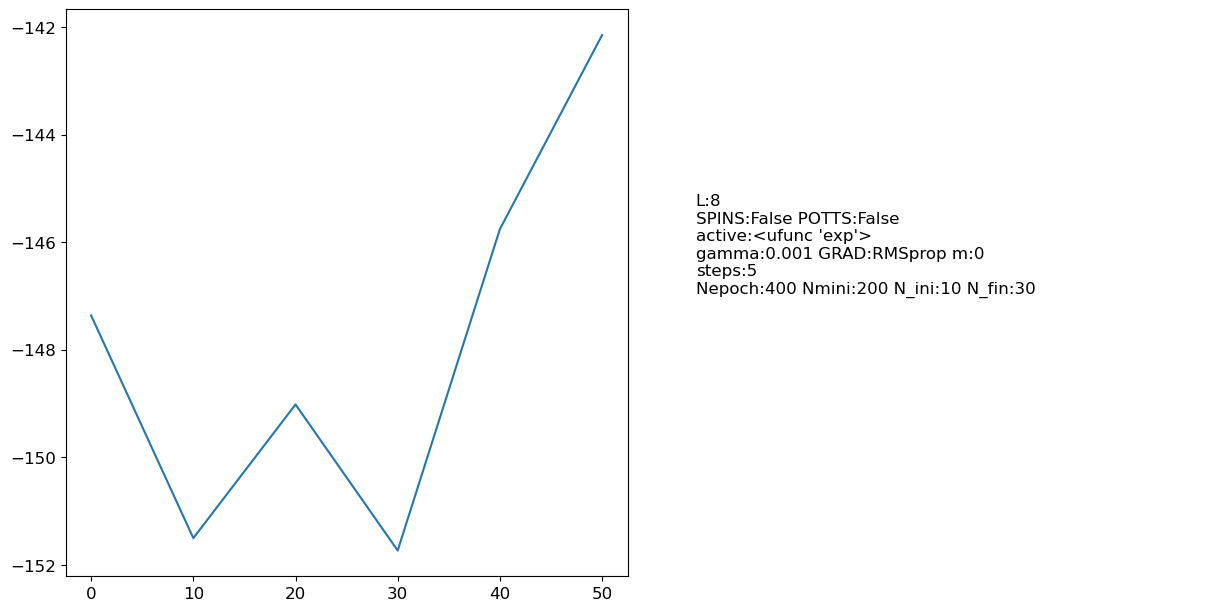

In [25]:
stringa = f'L:{L}\nSPINS:{SPINS} POTTS:{POTTS}\nactive:{active}\ngamma:{gamma} GRAD:{GRAD} m:{m}\nsteps:{Nt}\nNepoch:{Nepoch} Nmini:{Nmini} N_ini:{N_ini} N_fin:{N_fin}'

fig, ax = plt.subplots(1,2, figsize=(12,6), layout='constrained')

plot_stuff = np.loadtxt('llh2.txt', skiprows=2)
ax[0].plot(plot_stuff)
ax[0].set_xticks(list(range(len(plot_stuff))), list(range(0, len(plot_stuff) * 10, 10)))
ax[1].set_axis_off()
ax[1].text(.1,.5, stringa)
plt.show()

## Model scores
We plot the scores related to the 6 best models that we chose. We see that we get for all models approximately the same error bars and the same result.
We also note that five out of six models have as hyperparameter for the optimizer the value 'RMSprop', which indicates that maybe this value could be better than 'SGD'.


In [15]:
llh_list = []
file_names = []
with os.scandir() as files:
    for file in files:
        if file.name.startswith('llh') and file.name.endswith('.txt'):
            llh_list.append(np.loadtxt(file.name, skiprows=2))
            file_names.append(file.name)
print(file_names)

['llh1742540511.txt', 'llh2.txt', 'llh1742543445.txt', 'llh1742505624.txt', 'llh3.txt', 'llh1742541396.txt']


|Model|L|SPIN|POTTS|gamma|Nt|Nepoch|Nmini|Nini|Nfin|Grad|
|---|---|---|---|---|---|---|---|---|---|---|
|0|7|False|False|0.001|4|300|30|5|100|RMSprop|
|1|10| False| False|0.001| 1| 200| 10| 5|325| RMSprop|
|2|5|False|False|0.001|2|190|45|10|450|SGD|
|3|10|False|True|0.01|1|200|10|5|10|RMSprop|
|4|10| False| False|0.01| 1| 200| 10| 5| 10| RMSprop|
|5|10|False|False|0.001|7|350|10|5|325|RMSprop|


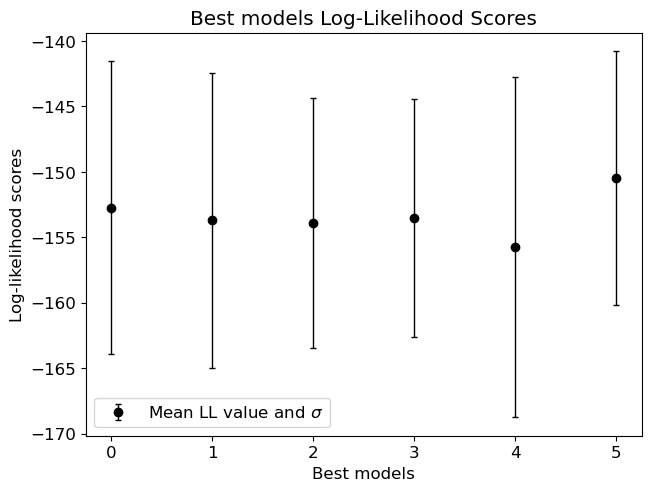

In [17]:
fig, ax = plt.subplots(layout='constrained')
ax.errorbar(range(len(llh_list)), np.mean(llh_list, axis=0), yerr=np.std(llh_list, axis=0), fmt='ok', lw=1, capsize=2, label='Mean LL value and $\\sigma$')
plt.title('Best models Log-Likelihood Scores')
plt.ylabel('Log-likelihood scores')
plt.xlabel('Best models')
plt.legend()
plt.show()

## Test generative power of the best model

Here we use model 5 to generate and show new data.

<Figure size 640x480 with 0 Axes>

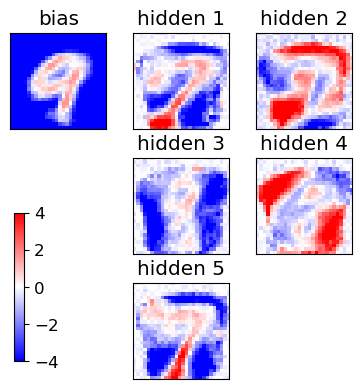

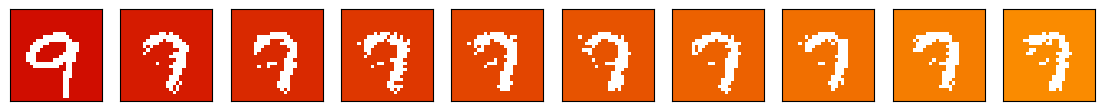

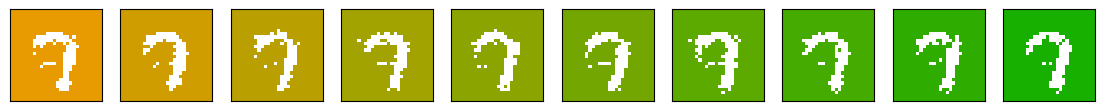

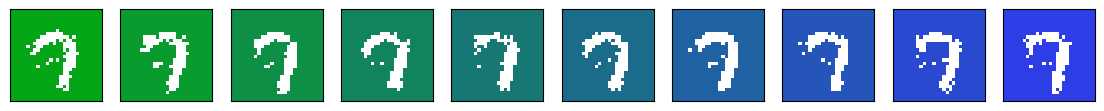

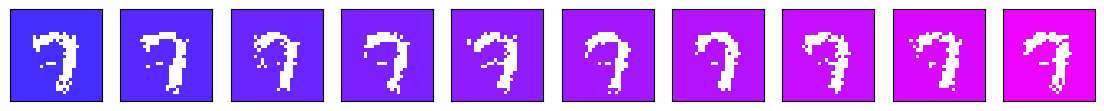

L: 5     amplification of weights: 5


In [65]:
ee=-1 ##
NN=200
traj_x,traj_z = np.zeros((NN+2,D)), np.zeros((NN+2,L))
xf=np.copy(data[np.random.randint(Nd)])
traj_x[0]=np.copy(xf)

# AF: multiply weights and biases by a number >1 to achieve a more deterministic behavior,
# equivalent to lower the temperature in a Boltzmann weight -> select lowest energies
# Note: here, this is done in the negative CD step only
AF=5

for t in range(NN):
    t1=t+1
    # positive CD phase: generating fantasy zf from fantasy xf
    zf = CD_step(xf,1*wE[ee],1*bE[ee], a_func=active, POTTS=POTTS)
    traj_z[t] = np.copy(zf)
    # negative CD pzase: generating fantasy xf from fantasy zf
    xf = CD_step(zf,AF*wE[ee].T, AF*aE[ee], a_func=active)
    traj_x[t1] = np.copy(xf)


plot_weights_bias(wE, aE, Nepoch, L, cols=Ncols, save=False)

col0,col1,col2,col3,col4=(0.8,0,0,1),(1,0.6,0,1),(0,.7,0,1),(0.2,0.2,1,1),(1,0,1,1)
show_MNIST(traj_x[0:],Nex=10,colors=(col0,col1))
show_MNIST(traj_x[10:],Nex=10,colors=(col1,col2))
show_MNIST(traj_x[20:],Nex=10,colors=(col2,col3))
show_MNIST(traj_x[40:],Nex=10,colors=(col3,col4))
print("L:",L,"    amplification of weights:",AF)

In [25]:
import os
from IPython.display import display
from PIL import Image
import matplotlib.pyplot as plt
import re

folder_path = "img/"
# regex
pattern = re.compile(r"LLH_epoch150_L(\d)_CD(\d+)_lr0.05.png")

files = [
    (f, int(match.group(1)), int(match.group(2)), os.path.join(folder_path, f))
    for f in os.listdir(folder_path)
    if (match := pattern.match(f)) 
]

# Sort by L first, then CD
files.sort(key=lambda x: (x[1], x[2]))
# Extract only filenames
sorted_filenames = [f[0] for f in files]

row,cols = 5,6
fig,axes = plt.subplots(row,cols, figsize=(15,10), layout='constrained', dpi=1000)
axes = axes.flatten()
for i, img in enumerate(sorted_filenames[:row*cols]):
    image = Image.open('img/' +img)
    axes[i].imshow(image)
    axes[i].axis('off')

plt.show()